In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

feature_list = ['lat', 'lon',
                        'TMP_P0_L1_GLL0', 'SPFH_P0_2L108_GLL0', 'RH_P0_L4_GLL0',
                        'PWAT_P0_L200_GLL0', 'UGRD_P0_L6_GLL0', 'GUST_P0_L1_GLL0',
                        'PRES_P0_L7_GLL0', 'CultivatedLand', 'WoodLand', 'GrassLand', 'Waters',
                        'UrbanRural', 'UnusedLand', 'Ocean', 'ELEVATION', 'AOD', 'month',
                        'year', 'weekday']
label_name = 'o3'

In [2]:
from sklearn.preprocessing import MinMaxScaler
train = pd.read_csv('day\\train_set_daily_new.csv')
test = pd.read_csv('day\\test_set_daily_new.csv')
X_train, y_train, X_test, y_test = train[feature_list], train[label_name],test[feature_list],test[label_name]
X_train = pd.get_dummies(X_train,columns = ['month','year','weekday'],drop_first=True)
X_test = pd.get_dummies(X_test,columns = ['month','year','weekday'],drop_first=True)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler,'scaler.joblib')
X_train_tensor = torch.tensor(X_train,dtype = torch.float32)
X_test_tensor = torch.tensor(X_test,dtype = torch.float32)

In [4]:
class Mynet(nn.Module):
    def __init__(self,input_size,hidden1,hidden2,hidden3,hidden4,output_size,dropout_prob):
        super(Mynet,self).__init__()
        self.fc1 = nn.Linear(input_size,hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.fc2 = nn.Linear(hidden1,hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden2,hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3)
        self.fc4 = nn.Linear(hidden3,hidden4)
        self.fc5 = nn.Linear(hidden4,output_size)
    def forward(self,x):
        x = self.fc1(x)
        feature1 = x
        x = self.bn1(x)
        x = F.relu(x)
    
        x = self.dropout(x)
        x = self.fc2(x)
        feature2 = x
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        feature3 = x
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc4(x)
        feature4 = x
        x = F.relu(x)
        out = self.fc5(x)
        return out,feature1,feature2,feature3,feature4


model = torch.load('day\\NN5.pth').to('cpu')

In [5]:
model

Mynet(
  (fc1): Linear(in_features=37, out_features=1680, bias=True)
  (bn1): BatchNorm1d(1680, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1680, out_features=2560, bias=True)
  (bn2): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=2560, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
X_train_transfered = model(X_train_tensor)[3]# the size of new feature is 256
X_test_transfered = model(X_test_tensor)[3]

In [7]:

X_train_transfered_numpy = X_train_transfered.detach().numpy()
X_test_transfered_numpy = X_test_transfered.detach().numpy()

In [8]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'device': 'gpu',  # Enable GPU training
    'gpu_platform_id': 0,  # Use the first GPU
    'gpu_device_id': 0,
    'num_leaves': 1500,
    'max_depth': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train_transfered_numpy, label=y_train)

# Train the model
num_rounds = 800
lgb_model = lgb.train(params, train_data, num_rounds)

In [9]:
lgb_model.save_model('model.txt')

In [16]:
lgb_model = lgb.Booster(model_file='model.txt')
y_pred = lgb_model.predict(X_test_transfered_numpy)

#y_test = y_test.to_numpy()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
smape = np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test))) * 100
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

from confidence import confidence
conf = confidence(y_test,y_pred,10)

print("RMSE:", rmse)
print("SMAPE:", smape)
print("MAE:", mae)
print("R2:", r2)
print('confidence',conf)

RMSE: 12.63556805891459
SMAPE: 17.782834952700433
MAE: 9.43022060572622
R2: 0.801388349631664
confidence 0.6357063236224505


C:\Users\Carlos\AppData\Local\Temp\ipykernel_7184\3289939180.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(abs(y_test-y_pred),


<Axes: ylabel='Density'>

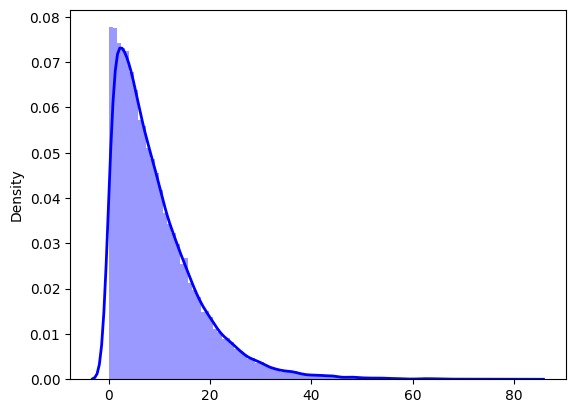

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(abs(y_test-y_pred), 
             bins=int(100), color = 'blue',
             kde_kws={'linewidth': 2})

In [11]:
a = pd.DataFrame({'actual':y_test,'pred':y_pred})
a.to_csv('test_set_performance.csv')